In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

import healpy as hp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

import hasasia.sensitivity as hassen
import hasasia.sim as hassim
import hasasia.skymap as hassky

import targeted_functions as fns

import glob
import scipy.stats as ss

Do not have mpi4py package.


In [2]:
datadir='/Users/caitlinawitt/Desktop/nano11'
p11 = np.loadtxt(datadir+'/psrlist_Tg3yr.txt', dtype='S42').astype('str')
p11 = list(p11)

In [3]:
p11 = sorted([x[1:] for x in p11])

In [4]:
p1=[]
for p in p11:
    if len(p)<len(p11[0]):
        a = 'B'+p
        p1.append(a)
    else:
        a = 'J'+p
        p1.append(a)
p11 = p1

In [5]:
noisefiles = sorted(glob.glob(datadir + '/noisefiles_new/*noise.txt'))
noisefiles = [x for x in noisefiles if x.split('/')[-1].split('_')[0] in p11]

setpars = {}
for nfile in noisefiles:
    setpars.update(fns.get_noise_from_pal2(nfile))

In [6]:
amp=[]
gamma=[]
for psr in p11:
    amp.append(10**setpars[psr+'_red_noise_log10_A'])
    gamma.append(setpars[psr+'_red_noise_gamma'])
alpha=(np.array(gamma)-3)/(-2)
amp = np.array(amp)

In [7]:
#Iguchi params
m1=1.2e9
m2=7e8
M_c=(m1*m2)**(3./5)/(m1+m2)**(1./5)
z = 0.0213
DL = 85.8
f_0 =6.04*10**(-8)

skypos = SkyCoord('02h23m11.4112s', '+42d59m31.385s', frame='icrs')
h_0_Circ = hassky.h0_circ(M_c,DL,f_0)

In [8]:
N_pulsar = 33
sigma = 100*u.ns.to('s')*u.s # 100 ns
cadence = 23/u.yr #number of observations/yr
f_min = cadence.to('1/s')/2. #nyquist frequency

In [9]:
rmss=np.array([0.361 ,0.691 ,0.454 , 0.422, 0.178 ,1.07 ,0.323 ,0.672 , 0.23 ,0.199 ,0.426 ,3.31 ,0.108 ,0.52 ,0.128 ,0.842 ,
           3.59 ,0.239,0.809 ,3.65 ,0.148 ,0.544, 0.322 ,0.229,0.57 ,0.352 ,0.377 ,0.257 ,0.11 ,0.12 ,0.968 ,1.33 ,1.07 ,0.271])*1e-6
#sorry this is disgusting, I'm lazy

In [10]:
coord = []
c_1713 = []
c_0613 = []
for i in range(len(p11)):
    if 'J' in p11[i]:
        if '+' in p11[i]:
            #if '1713' not in p11[i]:
            a = p11[i].split('J')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+c[2:4]+'m00s')
            coord.append(SkyCoord(ra, dec, frame='icrs'))

        else:
            a = p11[i].split('J')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+c[2:4]+'m00s')            
            coord.append(SkyCoord(ra, dec, frame='icrs'))
    else:
        if '+' in p11[i]:
            a = p11[i].split('B')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))
        else:
            a = p11[i].split('B')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))
            


In [70]:
T_obs_array = [11,15]*u.yr

N_11 = 34
N_12p5 = 45
N_9 = 18
N_per = (N_12p5-N_11)/1.5/u.yr
N = (N_11-N_9)/2/u.yr
N_p = np.mean([N_per.value, N.value])
N_per = 7/u.yr
N_psr = [int((N_11+N_per*t).value) for t in T_obs_array-T_obs_array[0]]

In [71]:
N_psr

[34, 62]

In [14]:

phi = np.array([c.ra.radian for c in coord])
theta = np.array([np.pi/2 - c.dec.radian for c in coord])
theta_3c = np.array(np.pi/2-skypos.dec.radian)
phi_3c = np.array(skypos.ra.radian)

In [15]:
theta_added = np.append(theta,0.)
theta_added2 = np.append(theta_added,np.pi)

phi_hist = np.histogram(phi, bins=np.linspace(0,2*np.pi,8))
theta_hist = np.histogram(theta_added2, bins=np.linspace(0,np.pi,8))
phi_dist = ss.rv_histogram(phi_hist)
theta_dist = ss.rv_histogram(theta_hist)
#making distributions to draw some new ones

In [76]:
curves_psrs_notnear=[]
freqs_sm = []
added_theta = np.array([])
added_phi = np.array([])
added_amp = np.array([])
added_alpha = np.array([])
added_rmss = np.array([])
ptas = []

for i,T_obs in enumerate(T_obs_array):
    

    
    Tspan = T_obs.to('s') #Tspan in seconds
    #Simulate a set of identical pulsars, with different sky positions.
    freqs = np.logspace(np.log10(1/(5*Tspan.value)),np.log10(f_min.value),500)
    if T_obs == T_obs_array[0]:
        psrs3 = hassim.sim_pta(timespan=T_obs.value,cad=23,sigma=rmss,#*T_obs_array[0]/T_obs,
                         phi=phi,theta=theta,A_rn=amp,alpha=alpha,freqs=freqs)
    else:
        N_add = int(N_psr[i] -N_psr[i-1])
        print(N_add)
        tspan = np.ones(N_psr[0])*T_obs
        print(len(tspan))
        for i in range(int(N_add/N_per.value)-1, -1, -1):
            print(i)
            a = np.ones(int(N_per.value))*3*u.yr+i*u.yr
            tspan = np.append(tspan,a).value*u.yr
            
            
        #Tspan = tspan.to('s')
        new_ind_30 = np.random.choice(range(len(rmss)), size = N_add)
        new_rmss = rmss[new_ind_30]
        new_amps = amp[new_ind_30]
        new_alpha = alpha[new_ind_30]
        new_theta = theta_dist.rvs(size = N_add) 
        new_phi = phi_dist.rvs(size=N_add)
        
        added_theta = np.append(added_theta,new_theta)
        added_phi = np.append(added_phi,new_phi)
        added_amp = np.append(added_amp,new_amps)
        added_alpha= np.append(added_alpha,new_alpha)
        added_rmss = np.append(added_rmss,new_rmss)
        
        print(len(tspan))

        #tspan = np.ones(N_psr[i])*T_obs
        psrs3 = hassim.sim_pta(timespan=tspan.value,cad=23,sigma=np.append(rmss,added_rmss),#*T_obs_array[0]/T_obs,
                         phi=np.append(phi,added_phi),theta=np.append(theta,added_theta),
                               A_rn=np.append(amp,added_amp),
                               alpha=np.append(alpha,added_alpha),
                               freqs=freqs)
    
    spectra3 = []
    for p in psrs3:
        sp = hassen.Spectrum(p, freqs=freqs)
        sp.NcalInv
        spectra3.append(sp)

    pta=hassen.DeterSensitivityCurve(spectra3)
    #Use the healpy functions to get the sky coordinates
    NSIDE = 32
    NPIX = hp.nside2npix(NSIDE)
    IPIX = np.arange(NPIX)
    theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)
    theta_gw = np.append(theta_gw,theta_3c)
    phi_gw = np.append(phi_gw,phi_3c)

    sky_loc = 'PTA Sensitivity at '
    sky_loc += '{0:2.1f}$^\circ$N, {1:2.1f}$^\circ$E'.format(np.rad2deg(theta_gw[-1]),
                                                   np.rad2deg(phi_gw[-1]))
    indx_f_0_pta = np.abs(pta.freqs-f_0).argmin()
    sky_map4 = hassky.SkySensitivity(spectra3,theta_gw, phi_gw)
    indx_f_0_SM = np.abs(sky_map4.freqs-f_0).argmin()
    curves_psrs_notnear.append(sky_map4.h_c[:,-1])
    freqs_sm.append(sky_map4.freqs)

    print(T_obs)

11.0 yr
28
34
3
2
1
0
62
15.0 yr


In [75]:
for i,T_obs in enumerate(T_obs_array):
    if T_obs == T_obs_array[0]:
        tspan = T_obs
    else:
    
        N_add = int(N_psr[i] -N_psr[i-1])
        print(N_add)
        tspan = np.ones(N_psr[0])*T_obs
        print(len(tspan))
        for i in range(int(N_add/N_per.value)-1, -1, -1):
            print(i)
            a = np.ones(int(N_per.value))*3*u.yr+i*u.yr
            tspan = np.append(tspan,a).value*u.yr
        print(len(tspan))

28
34
3
2
1
0
62


In [66]:
len(tspan)

62

In [67]:
tspan

<Quantity [15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
           15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
           15., 15., 15., 15., 15., 15., 15., 15.,  6.,  6.,  6.,  6.,  6.,
            6.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  4.,  4.,  4.,
            4.,  4.,  4.,  3.,  3.,  3.,  3.,  3.,  3.,  3.] yr>

Text(0, 0.5, 'GW Frequency')

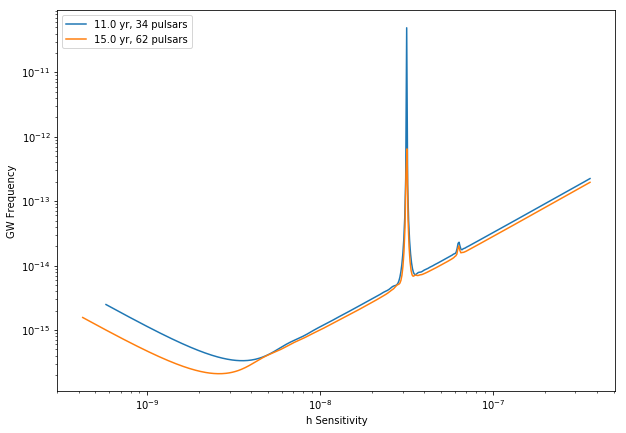

In [77]:
plt.figure(figsize=(10,7))
c = ['C0', 'C1', 'C2', 'C3', 'C4']
for i,T_obs in enumerate(T_obs_array):
    plt.loglog(freqs_sm[i], curves_psrs_notnear[i], label=str(T_obs)+', '+str(N_psr[i])+' pulsars', alpha = 1)


plt.legend(loc='upper left')
#plt.xlim(1e-8,1e-7)
#plt.ylim(1e-15,8e-14)
plt.xlabel('h Sensitivity')
plt.ylabel('GW Frequency')
#plt.savefig('/Users/caitlinawitt/Documents/3c66b/plots/sensitivity_curves.pdf')